In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Downloading and analyzing the dataset

In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [40]:
df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [41]:
print("Length of dataset = ", len(df))
print("Number of non-fraudulent transactions = ", df['Class'].value_counts()[0])
print("Number of fraudulent transactions = ", df['Class'].value_counts()[1])
print("Degree of imbalance =", df['Class'].value_counts()[0] / df['Class'].value_counts()[1])

Length of dataset =  284807
Number of non-fraudulent transactions =  284315
Number of fraudulent transactions =  492
Degree of imbalance = 577.8760162601626


([<matplotlib.patches.Wedge at 0x79b552ddb6e0>,
 [Text(-1.0999838024749575, 0.0059694466019511215, 'Non-Fraudulent'),
  Text(1.099983802996819, -0.005969350438309128, 'Fraudulent')],
 [Text(-0.5999911649863404, 0.0032560617828824297, '99.8%'),
  Text(0.5999911652709922, -0.0032560093299867964, '0.2%')])

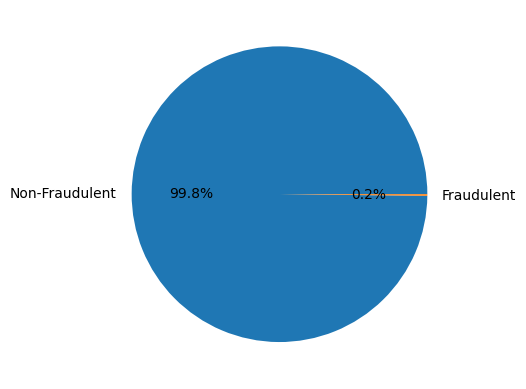

In [42]:
plt.pie(df['Class'].value_counts(), labels=['Non-Fraudulent', 'Fraudulent'], autopct='%1.1f%%')

We see that a vast majority of elements are of class 0 (non-fraudulent). Hence, the datset is highly imbalanced.

# The baseline model (without resampling)

In [43]:
fraudulent_set = df[df['Class'] == 1].to_numpy()
non_fraudulent_set = df[df['Class'] == 0].to_numpy()
y_fraudulent = np.ones(len(fraudulent_set))
y_non_fraudulent = np.zeros(len(non_fraudulent_set))
x_fraudulent = fraudulent_set[:, :-1]
x_non_fraudulent = non_fraudulent_set[:, :-1]

#train test split used separately on fraudulent and non-fraudulent data to preserve imbalance
x_fraudulent_train, x_fraudulent_test, y_fraudulent_train, y_fraudulent_test = train_test_split(x_fraudulent, y_fraudulent, test_size=0.2, random_state=42)
x_non_fraudulent_train, x_non_fraudulent_test, y_non_fraudulent_train, y_non_fraudulent_test = train_test_split(x_non_fraudulent, y_non_fraudulent, test_size=0.2, random_state=42)

#Concatenate to get the final train and test datasets
x_train = np.concatenate((x_fraudulent_train, x_non_fraudulent_train))
x_test = np.concatenate((x_fraudulent_test, x_non_fraudulent_test))
y_train = np.concatenate((y_fraudulent_train, y_non_fraudulent_train))
y_test = np.concatenate((y_fraudulent_test, y_non_fraudulent_test))

In [44]:
model_1 = LogisticRegression()
model_1.fit(x_train, y_train)
y_preds = model_1.predict(x_test)

#For storing classification reports for all models
reports = []

report = classification_report(y_test, y_preds, target_names = ['Non-Fraudulent', 'Fraudulent'])
print(report)
reports.append(report)

                precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     56863
    Fraudulent       0.65      0.63      0.64        99

      accuracy                           1.00     56962
     macro avg       0.83      0.81      0.82     56962
  weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Obsevation
Accuracy is a misleading metric here since although the model performs poorly on fraudelent data, the accuracy is high. This is because since 99.8% of the transactions are non-fraudulent, the model model can acquire high accuracy by classifying most of the transactions as non-fraudulent (even the fraudulent ones).

# SMOTE (Synthetic Minority Over-sampling Technique)
In this technique, k nearest neighbours of a minority class datapoint are chosen (all of which belong to the minority class). Oversampling is done by interpolating synthetic datapoints between the original point and its neighbours. A disadvantage is that it can amplify noise. If some points are mislabelled, a large number of noisy samples are created.

In [45]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority')
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
np.unique(y_train_smote, return_counts=True)

(array([0., 1.]), array([227452, 227452]))

# CBO (Clustering-Based Oversampling)
In this method, clustering is done on the minority class. Oversampling is done by generating synthetic datapoints from each cluster.

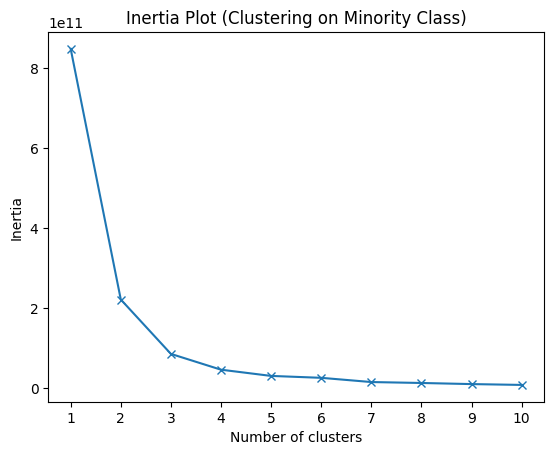

In [46]:
#Identify optimal number of clusters using elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_fraudulent_train)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, '-x')
plt.title('Inertia Plot (Clustering on Minority Class)')
plt.xlabel('Number of clusters')
plt.xticks(range(1, 11))
plt.ylabel('Inertia')
plt.show()

From the inertia plot, we choose k = 3

In [47]:
#Create clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_fraudulent_train)

KMeans(n_clusters=3, random_state=42)

In [48]:
x_fraudulent_synthetic = []
for i in range(kmeans.n_clusters):
    cluster = x_fraudulent_train[kmeans.labels_ == i]

    mean = np.mean(cluster, axis=0)
    cov = np.cov(cluster, rowvar=False)

    # Add a small value to the diagonal for stability
    cov = cov + np.eye(cov.shape[0]) * 1e-6

    # Sample from multivariate Gaussian and maintain the proportion of points from each cluster
    synthetic_points = np.random.multivariate_normal(mean, cov, len(x_non_fraudulent_train)*len(cluster)//len(x_fraudulent_train))
    x_fraudulent_synthetic.append(synthetic_points)

# Concatenate synthetic data from all clusters
x_fraudulent_synthetic = np.concatenate(x_fraudulent_synthetic, axis=0)

In [49]:
x_train_cbo = np.concatenate((x_non_fraudulent_train, x_fraudulent_synthetic))
y_train_cbo = np.concatenate((np.zeros(len(x_non_fraudulent_train)), np.ones(len(x_fraudulent_synthetic))))
print(len(x_non_fraudulent_train))
print(len(x_fraudulent_synthetic))

227452
227451


# CBU
Here, clustering is done on the majority class. Points are sampled from the clusters proportional to its size.

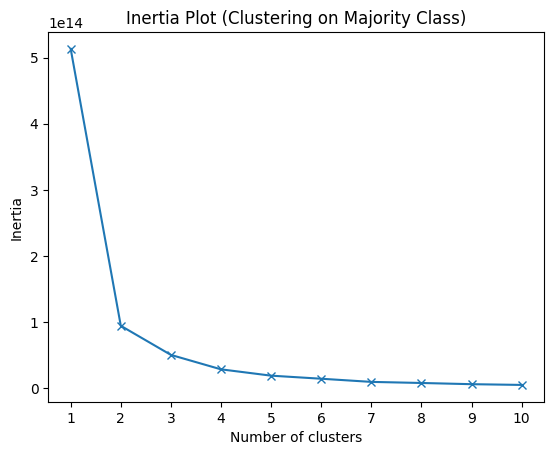

In [50]:
#Clustering on majority class
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_non_fraudulent_train)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, '-x')
plt.title('Inertia Plot (Clustering on Majority Class)')
plt.xlabel('Number of clusters')
plt.xticks(range(1, 11))
plt.ylabel('Inertia')
plt.show()

From the inertia plot, we choose k = 3.

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_non_fraudulent_train)

samples = []
for i in range(kmeans.n_clusters):
  cluster = x_non_fraudulent_train[kmeans.labels_ == i]
  # Sampling from each cluster maintaining the proportion of points from each cluster
  indices = np.random.randint(0, len(cluster), len(x_fraudulent_train)*len(cluster)//len(x_non_fraudulent_train))
  samples.append(cluster[indices])

samples = np.concatenate(samples, axis=0)
x_train_cbu = np.concatenate((samples, x_fraudulent_train))
y_train_cbu = np.concatenate((np.zeros(len(samples)), np.ones(len(x_fraudulent_train))))
print(len(samples))
print(len(x_fraudulent_train))

392
393


# Performance of models with resampling

## SMOTE

In [52]:
model_2 = LogisticRegression()
model_2.fit(x_train_smote, y_train_smote)
y_preds_smote = model_2.predict(x_test)
report = classification_report(y_test, y_preds_smote, target_names = ['Non-Fraudulent', 'Fraudulent'])
print(report)
reports.append(report)

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56863
    Fraudulent       0.08      0.90      0.14        99

      accuracy                           0.98     56962
     macro avg       0.54      0.94      0.57     56962
  weighted avg       1.00      0.98      0.99     56962



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## CBO

In [53]:
model_3 = LogisticRegression()
model_3.fit(x_train_cbo, y_train_cbo)
y_preds = model_3.predict(x_test)
report = classification_report(y_test, y_preds, target_names = ['Non-Fraudulent', 'Fraudulent'])
print(report)
reports.append(report)

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.97      0.98     56863
    Fraudulent       0.05      0.93      0.10        99

      accuracy                           0.97     56962
     macro avg       0.53      0.95      0.54     56962
  weighted avg       1.00      0.97      0.98     56962



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## CBU

In [54]:
model_4 = LogisticRegression()
model_4.fit(x_train_cbu, y_train_cbu)
y_preds = model_4.predict(x_test)
report = classification_report(y_test, y_preds, target_names = ['Non-Fraudulent', 'Fraudulent'])
print(report)
reports.append(report)


                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.95      0.98     56863
    Fraudulent       0.03      0.96      0.07        99

      accuracy                           0.95     56962
     macro avg       0.52      0.96      0.52     56962
  weighted avg       1.00      0.95      0.97     56962



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Summary table of performance on fraudulent transactions

In [55]:
#Summary table
summary_fraud_transactions = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score'])
summary_fraud_transactions['Model'] = ['Baseline', 'SMOTE', 'CBO', 'CBU']
for i in range(4):
  for j in range(1, 4):
    summary_fraud_transactions.iloc[i, j] = reports[i].split('\n')[3].split()[j]
summary_fraud_transactions

,Model,Precision,Recall,F1-Score
0,Baseline,0.65,0.63,0.64
1,SMOTE,0.08,0.90,0.14
2,CBO,0.05,0.93,0.10
3,CBU,0.03,0.96,0.07


# Conclusions

##Benefits and drawbacks of the methods
SMOTE is better than naive oversampling (i.e., randomly sampling from the minority class with replacement) as it ensures diversity. A disavantage of SMOTE is its tendency to amplify noisy data.

Cluster-based methods overcome this limitation. Noisy points are usually in small clusters and are therefore, not many points are sampled from those clusters. An advantage of CBU is that we sample actual points from the dataset rather than synthetic points (like in CBO). An advantage of CBO over CBU is that the entire majority class training set is preserved.

##Performance analysis and recommendation
The baseline model has a recall of only 0.63 on fraudulent transactions, which means that it can correctly identify only 63% of fraudulent transactions. SNMOTE, CBO and CBU significantly impove recall but at the cost of precision.

 Since a vast majority of transactions are non-fraudulent, even if a small percentage of them are incorrectly classified, this leads to a very low precision on fraudulent transactions (which means that most transactions that are classified as fraudulent are actually legitimate).

In this problem, recall is more important than precision because the cost of a fraudulent transcation being allowed is greater than the cost of a legitimate transaction being blocked. CBU has the highest recall. This could be because actual data points are used rather than synthetic data points.
Therefore, CBU is the recommended method as it has the highest recall on fraudulent transactions.
